### Przykład wyceny opcji europejskiej metodą monte carlo
Na zajęciach wycenialiśmy opcje na akcje spółki TAURONPE, niestety na GPW dostępne są opcje tylko na WIG20, dla porównania z realną ceną na rynku w poniższym przykładzie wyceniona zostanie opcja kupna na WIG20 o terminie realizacji styczeń 2017 ( https://www.gpw.pl/opcje )

In [1]:
import numpy as np
import pandas as pd

#### Przygotowanie danych

In [2]:
# wcztanie notowań WIG20 (dane pobrane z bossa.pl)
wig = pd.read_csv('WIG20.txt')
len(wig)

5630

In [3]:
wig.head(10)

,Name,Date,Open,High,Low,Close,Volume
0,WIG20,19940414,1000.0,1000.0,1000.0,1000.0,35800.0
1,WIG20,19940418,1050.5,1050.5,1050.5,1050.5,49975.0
2,WIG20,19940419,1124.9,1124.9,1124.9,1124.9,69029.5
3,WIG20,19940421,1304.8,1304.8,1304.8,1304.8,77075.5
4,WIG20,19940425,1350.1,1350.1,1350.1,1350.1,114219.0
5,WIG20,19940426,1216.2,1216.2,1216.2,1216.2,8309.0
6,WIG20,19940428,1096.7,1096.7,1096.7,1096.7,16342.5
7,WIG20,19940505,1138.1,1138.1,1138.1,1138.1,56888.5
8,WIG20,19940506,1077.6,1077.6,1077.6,1077.6,68955.0
9,WIG20,19940509,1035.6,1035.6,1035.6,1035.6,48545.5


In [4]:
wig.tail(10)

,Name,Date,Open,High,Low,Close,Volume
5620,WIG20,20161117,1761.95,1766.31,1739.73,1742.39,494463.691
5621,WIG20,20161118,1736.82,1741.60,1717.55,1725.74,508117.755
5622,WIG20,20161121,1731.39,1757.81,1731.39,1756.35,679537.248
5623,WIG20,20161122,1765.41,1779.86,1765.41,1775.66,604597.284
5624,WIG20,20161123,1772.69,1796.63,1772.66,1796.63,637727.304
5625,WIG20,20161124,1798.00,1811.99,1795.48,1807.27,415179.072
5626,WIG20,20161125,1810.46,1812.80,1785.16,1796.30,599206.527
5627,WIG20,20161128,1794.64,1796.61,1774.67,1776.30,465582.746
5628,WIG20,20161129,1777.84,1785.08,1771.13,1780.04,561733.341
5629,WIG20,20161130,1783.45,1808.78,1783.06,1798.22,1270309.852


In [5]:
# mamy dane dzienne od 199404.14 do 2016.11.30
# do wyliczenia zmienności historycznej weźmiemy tylko done od 2015 roku
# i wystarczą nam tylko ceny zamknięcia
wig = wig[['Date', 'Close']]
# kolumna Date jako obiekt datetime
wig['Date']=wig['Date'].apply(pd.to_datetime, format='%Y%m%d')

In [6]:
# kolumna date jako indeks tabeli
wig = wig.set_index('Date')
wig.head(10)

,Close
Date,
1994-04-14,1000.0
1994-04-18,1050.5
1994-04-19,1124.9
1994-04-21,1304.8
1994-04-25,1350.1
1994-04-26,1216.2
1994-04-28,1096.7
1994-05-05,1138.1
1994-05-06,1077.6


In [7]:
# dane tylko od 2015
wig = wig[wig.index >= pd.datetime(2015, 1, 1)]
wig.head()

,Close
Date,
2015-01-02,2309.39
2015-01-05,2264.75
2015-01-07,2307.46
2015-01-08,2361.48
2015-01-09,2337.21


#### Zmienność historyczna

In [8]:
# pomocnicza kolumna przesunięta o 1 przesuniecie o jeden
wig['Close_temp'] = wig['Close'].shift(1)
# logarytmiczne stopy zwrotu
wig['Log_ret'] = np.log(wig['Close']/wig['Close_temp'])
# usunięcie pomocniczej kolumny
wig = wig[['Close','Log_ret']]
# usunięcie NaN
wig = wig.dropna()
wig.head()

,Close,Log_ret
Date,,
2015-01-05,2264.75,-0.019519
2015-01-07,2307.46,0.018683
2015-01-08,2361.48,0.023141
2015-01-09,2337.21,-0.010331
2015-01-12,2330.04,-0.003072


In [9]:
# zmienność dzienna
v = np.var(wig['Log_ret'].values) # wariancja
s = np.sqrt(v) #odchylenie standardowe
# zmienność roczna
SIG = np.sqrt(252)*s
print(SIG)

0.181441747772


#### Model ceny akcji, model Blacka-Scholesa

In [10]:
# cena akcji nastepnego dnia
# c_p cena poprzednio
# r - stopa wolna od ryzyka
# s - zmienność
def cena_akcji(c_p, r, s):
    ran = np.random.randn() # zmienna losowa o rozkładzie N(0,1)
    return c_p*np.exp((r-0.5*s**2)*(1./252) + s*np.sqrt(1./252)*ran)

#### Wycena opcji kupna, symulaca monte carlo

In [11]:
# parametry
N = 100000 # liczba symulacji
T = 36 # czas do wygaśniecia opcji 20.01.2017
S0 = wig['Close'][-1] # cena poczatkowa 30.11.2016
K = 1800 # cena wykonania
r = 0.017 # stopa wolna od ryzyka, rentownosc 2letnich obligacji
s = SIG # zmiennosc historyczna
print(N,T,S0,K,r,s)

100000 36 1798.22 1800 0.017 0.181441747772


In [12]:
# monte carlo
ceny = []
for i in range(N):
    cena_p = S0
    for t in range(T):
        cena_n = cena_akcji(cena_p, r, s)
        cena_p = cena_n
    ceny.append(cena_n)

# wypłaty
W = np.array(ceny) - K
W = np.array([el if el > 0 else 0 for el in W])
# średnia wypłata
avg_W = np.average(W)
# zdyskontowana średnia wypłata, cena opcji
cena_opcji = np.exp(-r*(T/252.0))*avg_W
print(cena_opcji)

50.2506671815


Cena opcji na gpw w dniu 30.11.2016: od 45.50 do 47.00 

Trajektorie - realizacje

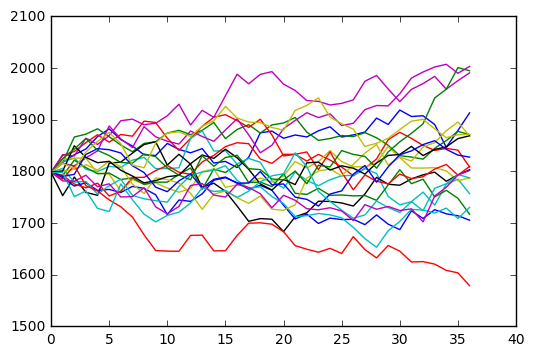

In [13]:
import matplotlib.pyplot as plt
#%matplotlib tk
N = 20
ceny = []
for i in range(N):
    cena = [S0]
    for t in range(T):
        cena.append(cena_akcji(cena[-1], r, s))
    ceny.append(cena)

fig = plt.figure()
for tr in ceny:
    plt.plot(tr)
plt.show()